In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('CropYield.csv')

In [3]:
provinces = ['Ha_Noi', 'Hai_Duong', 'Hung_Yen', 'Nam_Dinh', 'Ninh_Binh', 'Thai_Binh', 'Ha_Nam', 'Thanh_Hoa', 'Nghe_An', 'Ha_Tinh', 'Quang_Binh', 'Quang_Tri', 'Hue', 'Long_An', 'Tien_Giang', 'Ben_Tre', 'Tra_Vinh', 'Dong_Thap', 'An_Giang', 'Kien_Giang', 'Can_Tho', 'Soc_Trang', 'Bac_Lieu', 'Ca_Mau']
colors = ['rosybrown', 'lightcoral', 'maroon', 'red', 'tomato', 'darksalmon', 'sienna', 'chocolate', 'orange', 'darkgoldenrod', 'darkolivegreen', 'darkseagreen', 'turquoise', 'darkcyan', 'deepskyblue', 'slategray', 'cornflowerblue', 'navy', 'slateblue', 'blueviolet', 'mediumorchid', 'darkmagenta', 'mediumvioletred', 'crimson', 'lightpink']

Model built on Training Set in order to determine which degree leads to best MSE on Testing Set

In [4]:
tscv = TimeSeriesSplit(n_splits=5, test_size=1)

def MSE(X, y):
    
    X = np.array(X)
    y = np.array(y)
    
    MSE_validation = 0
    
    for (train_index, test_index) in (tscv.split(X)):
        
        linear_model = LinearRegression().fit(X[train_index], y[train_index])
        
        MSE_validation += mean_squared_error(y_true=y[test_index], y_pred=linear_model.predict(X[test_index]))
        
        del linear_model

    return MSE_validation/4

In [5]:
def best_degree(X, y):

    ans = 0

    best_mse = 99999999
    
    for degree in range(1, 20):

        poly = PolynomialFeatures(degree=degree, include_bias=False)

        X_poly = poly.fit_transform(X)

        MSE_test = MSE(X=X_poly, y=y)

        if (MSE_test < best_mse):
            ans = degree
            best_mse = MSE_test
    
    return ans

In [6]:
degrees = []

for province in provinces:

    X = np.arange(0, 28).reshape(-1, 1)

    y = df.loc[df['Province'] == province]['CropYield']
    
    degrees.append(best_degree(X, y))


degrees

[3, 3, 3, 1, 3, 2, 3, 3, 3, 1, 3, 1, 3, 2, 1, 1, 2, 2, 2, 2, 1, 3, 1, 1]

In [7]:
table = pd.DataFrame(columns=['Year', 'Province', 'RandomCropYield'])

def export(province, random_yield):
    
    for year in range(1995, 2023):
        row = [year, province]

        row.append(random_yield[year - 1995])

        table.loc[len(table)] = row

In [8]:
def yield_trend(degree, province):
    X = np.arange(0, 28).reshape(-1, 1)

    y = df.loc[df['Province'] == province]['CropYield']

    X_poly = PolynomialFeatures(degree=degree, include_bias=False).fit_transform(X)

    linear_model = LinearRegression().fit(X_poly, y)

    y_predicted = linear_model.predict(X_poly)

    export(province=province, random_yield=list(y - y_predicted))

    return (y_predicted, linear_model.coef_, linear_model.intercept_)

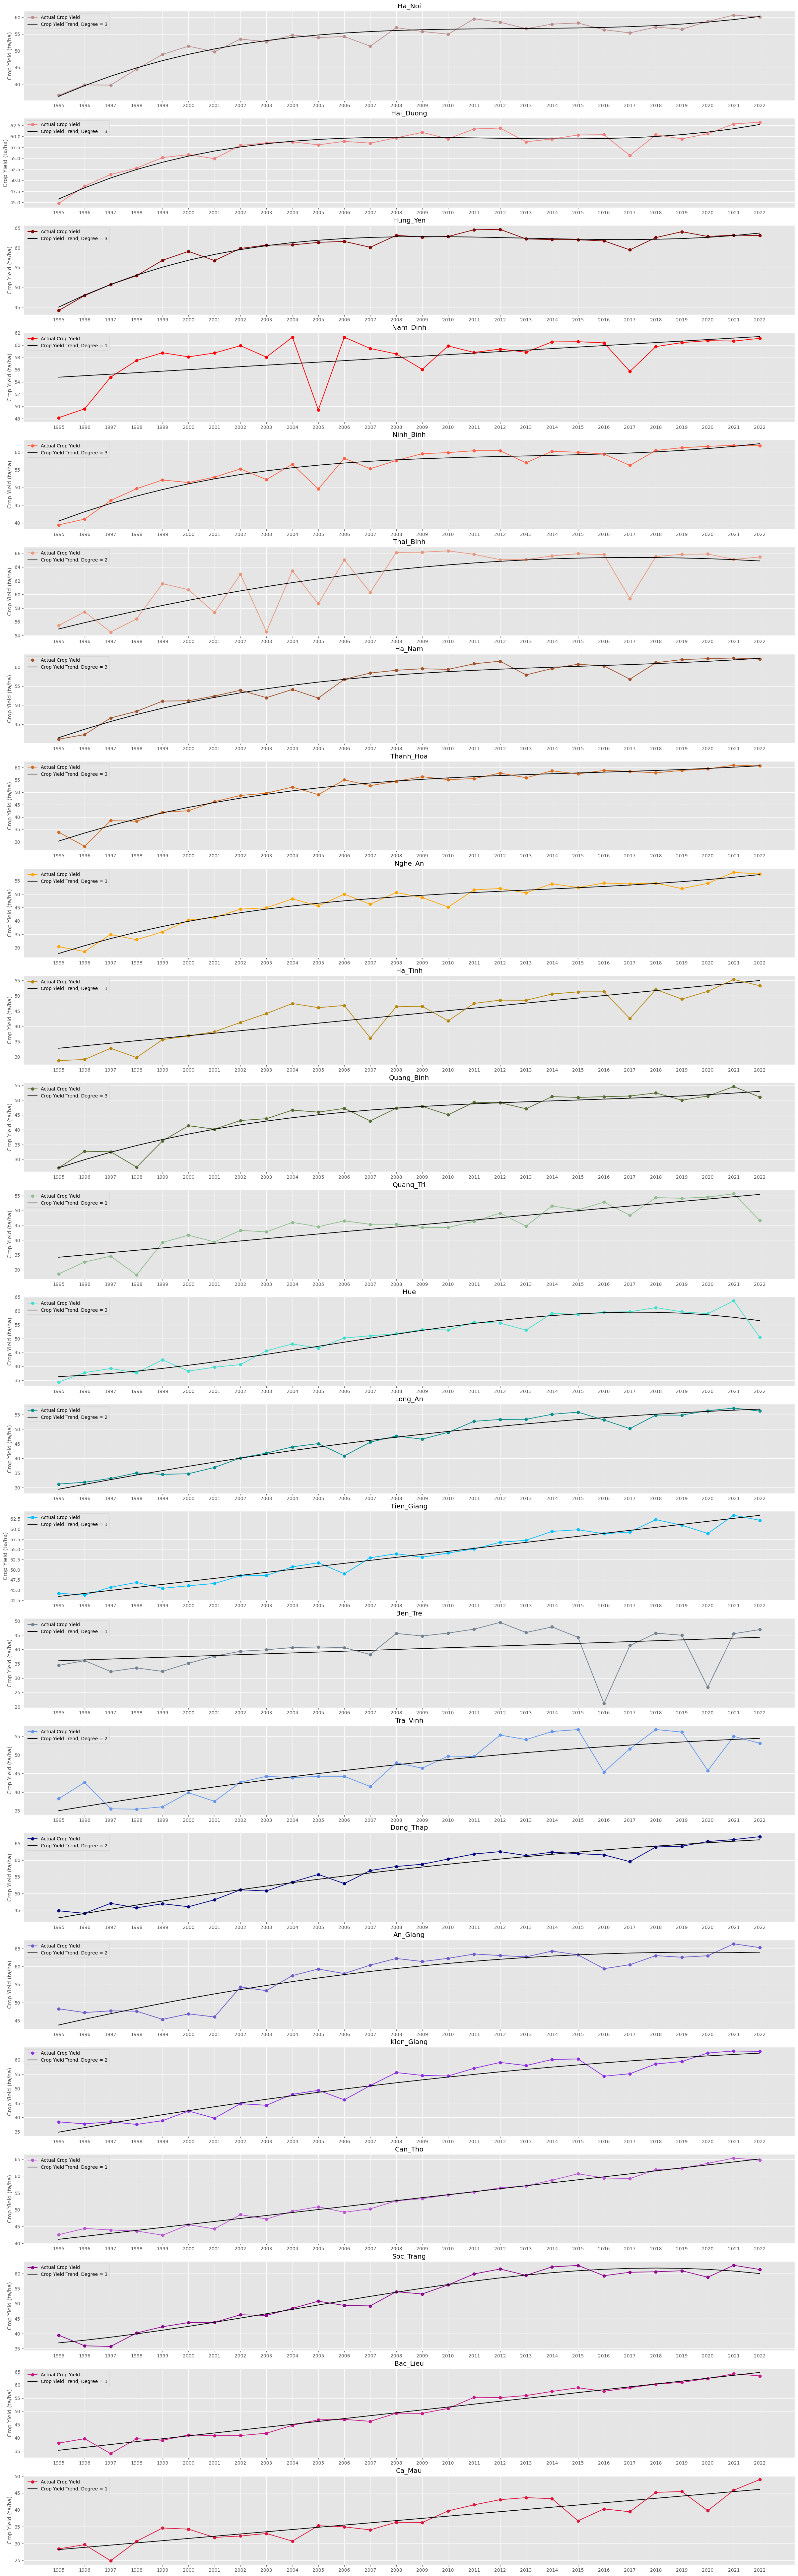

In [9]:
coefs = []
intercepts = []

nrows = 24
ncols = 1

plt.style.use('ggplot') 

fig = plt.figure(figsize=(30, 100))

for id, province in enumerate(provinces):
    
    crop_yield_trend, coef, intercept = yield_trend(degree=degrees[id], province=province)

    #Collect coefficients & intercepts
    coefs.append(coef)
    intercepts.append(intercept)

    #Plotting crop yield trend, and comparing with actual crop yield
    actual_crop_yield = df.loc[df['Province'] == province]['CropYield']

    ax = fig.add_subplot(nrows, ncols, id + 1)
    ax.plot(np.arange(1995, 2023), actual_crop_yield, marker='o', c=colors[id], label='Actual Crop Yield')
    ax.plot(np.arange(1995, 2023), crop_yield_trend, c='black', label='Crop Yield Trend, Degree = ' + str(degrees[id]))

    ax.legend()
    ax.set_xticks(np.arange(1995, 2023, dtype=int), list(map(str, list(np.arange(1995, 2023)))))
    ax.set_title(province)

    # ax.set_xlabel('Year') 
    ax.set_ylabel('Crop Yield (ta/ha)')

    del actual_crop_yield

# plt.legend()
plt.show()


In [10]:
for i, province in enumerate(provinces):
    print(province, degrees[i], coefs[i], intercepts[i])

Ha_Noi 3 [ 3.35443792 -0.18883612  0.00360052] 36.468173652758644
Hai_Duong 3 [ 2.72115296 -0.17134229  0.00347422] 45.751097561601505
Hung_Yen 3 [ 3.2142481  -0.1878783   0.00349728] 45.035972099827134
Nam_Dinh 1 [0.24582963] 54.774065522894404
Ninh_Binh 3 [ 2.75926607e+00 -1.45230822e-01  2.70287802e-03] 40.54147327229574
Thai_Binh 2 [ 0.94495503 -0.02135528] 54.95134504637922
Ha_Nam 3 [ 2.31809835e+00 -1.02945002e-01  1.69033411e-03] 41.461868591703336
Thanh_Hoa 3 [ 3.40698543e+00 -1.50558072e-01  2.44615734e-03] 30.307916281068024
Nghe_An 3 [ 3.05690031e+00 -1.44962346e-01  2.67079102e-03] 27.875522728240128
Ha_Tinh 1 [0.82053567] 32.83392757470252
Quang_Binh 3 [ 2.87639894e+00 -1.30827317e-01  2.21082257e-03] 27.16084982564079
Quang_Tri 1 [0.78482215] 34.232297775126845
Hue 3 [ 0.36406063  0.10696157 -0.0034391 ] 36.329650284350066
Long_An 2 [ 1.69950229 -0.02530659] 29.412814563075724
Tien_Giang 1 [0.73715198] 43.4650117491652
Ben_Tre 1 [0.30406036] 36.05611306691065
Tra_Vinh 2 [

In [13]:
table.loc[(table['Year'] >= 2000) & (table['Year'] <= 2020)].to_csv('RandomCropYield(Regression).csv', index=False)

In [12]:
table

,Year,Province,RandomCropYield
0,1995,Ha_Noi,0.281715
1,1996,Ha_Noi,0.211525
2,1997,Ha_Noi,-2.649514
3,1998,Ha_Noi,-0.377981
4,1999,Ha_Noi,1.853100
...,...,...,...
667,2018,Ca_Mau,1.760890
668,2019,Ca_Mau,1.351883
669,2020,Ca_Mau,-5.009864
670,2021,Ca_Mau,0.421440
